In [1]:
#TODO: 

# This would be a cell where you can just plug in a filename and it will do everything in this notebook for you 
# We'll do this later... Once we flush out the preprocessing.

In [2]:
#TODO: 

# Consider certainty of a learned word depending on how long they took to respond
# 	Keep a variable that tracks the time between all answers have been shown, and the user's answer input (given that they didn't skip).
#	We will consider this as how certain they are about their answer (longer time = less certain)

In [3]:
#TODO:

# A way to combine all the data we have from the various csv files and pass it into this code
# or make a list of files to access and just have them build on each other at the end of the file

Step 1: Load EEG data

In [4]:
# Install
!pip install mne
!pip install pandas
!pip install numpy

# For EEG
import mne

# For dataframes, graphs, and general stuff
import pandas as pd
import numpy as np

# For EEG
from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap

# For UTC and UNIX timezones (headache)
from datetime import datetime, timezone, timedelta
import pytz

# For something... I don't know this might be a typo.
import re

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [5]:
# This is just settings so that we can see the full DataFrame without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.expand_frame_repr', False)  # Don't wrap row

Creating RawArray with float64 data, n_channels=23, n_times=723402
    Range : 0 ... 723401 =      0.000 ...  2836.867 secs
Ready.
Using matplotlib as 2D backend.


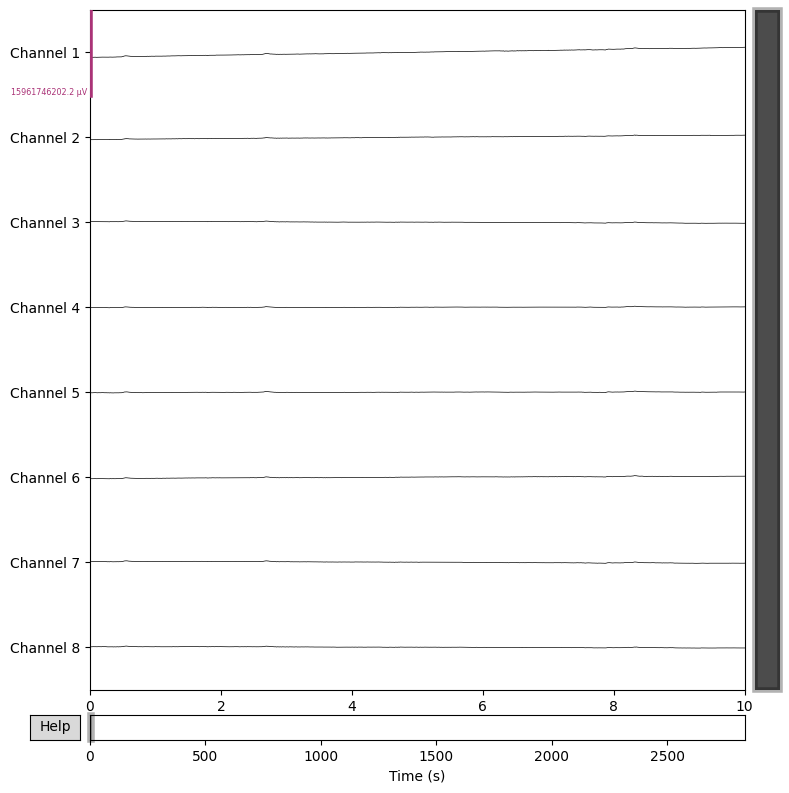

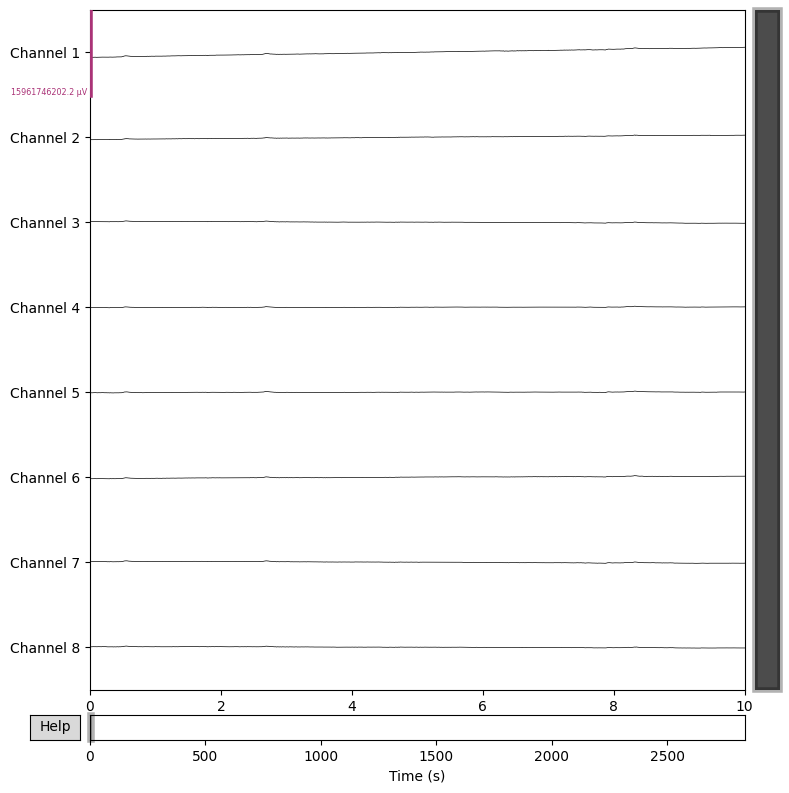

In [ ]:
### Step 1. Load EEG Data ###

# Helper functions to convert from UNIX time to UTC time
# UNIX time is saved as an integer (seconds since 1/1/1970)
# UTC time is saved as a string ("YYYY-MM-DDTHH:MM:SSZ")
def unix_to_utc(unix_timestamp):
	utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
	local_timezone = pytz.timezone('America/Los_Angeles')
	local_time = utc_time.astimezone(local_timezone) # This gives our UTC time converted to PST
	return utc_time # This gives our raw UTC time
def utc_to_unix(utc_time_str):
    utc_time = datetime.strptime(utc_time_str, "%Y-%m-%dT%H:%M:%SZ")
    utc_time = utc_time.replace(tzinfo=timezone.utc)
    unix_timestamp = int(utc_time.timestamp())
    return unix_timestamp

# Function to load the data. Simply enter a file path
def load_eeg_data(file_path):

	# Create a dataframe from our data, replace NAs with 0s
	df = pd.read_csv(file_path, sep='\t', skiprows=2, header=None)
	df.fillna(0.0, inplace=True)

	# Extract EEG data
	trial_data = df.iloc[:, 1:24].values

	# Declares channel names and types of each set of data
	sfreq = 255  # sample rate in Hz
	ch_names = ['Channel {}'.format(i+1) for i in range(trial_data.shape[1])]
	ch_types = ['eeg' for i in range(trial_data.shape[1])]

	# Get the measurement date
	start_time_unix = trial_data[0][21] # This is where EEG start time is stored in UNIX time
	meas_date = unix_to_utc(start_time_unix) # However, MNE takes UTC time

	# Create info structures and RawArray objects for each set of data
	info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
	info.set_meas_date(meas_date)
	raw = mne.io.RawArray(trial_data.T, info)

	# Removing irrelevant channels
	ch_names = [raw.ch_names]
	ch_names_to_keep = [ch_names[0][0:8]]
	raw = raw.pick(ch_names_to_keep[0])

	# Now you can work with the MNE Raw object
	# print(raw.info)
	# raw.plot(scalings='auto')
	# raw.__len__()
	# More attributes here: https://mne.tools/1.8/generated/mne.io.RawArray.html

	# Return the RawArray object
	return raw

# Store our EEG data path in a variable
eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_9_2025_JoshIrby_OpenBCI/OpenBCISession_2025-03-09_14-39-02/BrainFlow-RAW_2025-03-09_14-39-02_0.csv'
#eeg_file_path_csv = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_13_2025_JoshuaWei_OpenBCI/OpenBCISession_2025-03-13_19-40-36/BrainFlow-RAW_2025-03-13_19-40-36_0.csv'

# Actual function call
raw = load_eeg_data(eeg_file_path_csv)

# Make a cool picture
raw.plot(scalings='auto')

Step 2: Load PsychoPy data

In [ ]:
### Step 2.1 Load PsychoPy Data ###

# Helper function, converts PsychoPy's timestamp into UNIX
def psychopy_to_unix(psychopy_time):
    
    # Define the format of the input timestamp
    format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

    # Parse the custom timestamp into a datetime object
    parsed_timestamp = datetime.strptime(psychopy_time, format_string)

    # Convert the datetime object to a Unix timestamp (floating-point for microseconds)
    unix_timestamp = parsed_timestamp.timestamp()

    # Print the Unix timestamp
    return unix_timestamp

# Function to load psychopy data. Simply input the file path
def load_psychopy_data(file_path):

	# Read psychopy data into a pandas dataframe
	psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)
    
	#create a new column for the unix time of psychopy stimuli
	psychopy_df = psychopy_df.dropna(subset=["expStart"])
	psychopy_df["expStart"] = psychopy_df["expStart"].astype(str)
	psychopy_df["unix_time"] = psychopy_df["expStart"].apply(psychopy_to_unix)
    
	return psychopy_df

# Store our PsychoPy data in a variable
psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.csv'
#psyhcopy_file_path_csv = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)\PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.csv'

# Actual function call
psychopy_df = load_psychopy_data(psyhcopy_file_path_csv)

# Make sure it works
psychopy_df.head()

<>:33: SyntaxWarning: invalid escape sequence '\P'
<>:33: SyntaxWarning: invalid escape sequence '\P'
C:\Users\cheng\AppData\Local\Temp\ipykernel_23324\2455149348.py:33: SyntaxWarning: invalid escape sequence '\P'
  psyhcopy_file_path_csv = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)\PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.csv'
C:\Users\cheng\AppData\Local\Temp\ipykernel_23324\2455149348.py:22: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,23,33,37,44,50,61,62,227,286,290,322,333,350,354,366,376,385,402,411,428,445,455,466,501,508,516,517) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


,symbols,amharic_set1,words_set1,amharic_set2,words_set2,amharic_set3,words_set3,amharic_set4,words_set4,amharic_practices,words_practice,image_practice,thisN,thisTrialN,thisRepN,debugging_press_enter_to_skip_24.keys,debugging_press_enter_to_skip_4.keys,debugging_press_enter_to_skip_5.keys,debugging_press_enter_to_skip_25.keys,key_resp_10.keys,key_resp_10.corr,key_resp_10.rt,key_resp_10.duration,debugging_press_enter_to_skip_23.keys,debugging_press_enter_to_skip_7.keys,debugging_press_enter_to_skip_15.keys,debugging_press_enter_to_skip_23.rt,debugging_press_enter_to_skip_23.duration,debugging_press_enter_to_skip_26.keys,debugging_press_enter_to_skip.keys,key_resp_11.keys,key_resp_11.rt,key_resp_11.duration,key_resp_5.keys,key_resp_5.corr,key_resp_5.rt,key_resp_5.duration,debugging_press_enter_to_skip_19.keys,debugging_press_enter_to_skip_19.rt,debugging_press_enter_to_skip_19.duration,key_resp_12.keys,key_resp_12.rt,key_resp_12.duration,debugging_press_enter_to_skip_9.keys,key_resp_6.keys,key_resp_6.corr,key_resp_6.rt,key_resp_6.duration,debugging_press_enter_to_skip_20.keys,debugging_press_enter_to_skip_11.keys,key_resp_7.keys,key_resp_7.corr,key_resp_7.rt,key_resp_7.duration,debugging_press_enter_to_skip_21.keys,debugging_press_enter_to_skip_13.keys,key_resp_8.keys,key_resp_8.corr,key_resp_8.rt,key_resp_8.duration,debugging_press_enter_to_skip_22.keys,answer_box.text,enter.keys,enter.rt,enter.duration,LoopParameters.thisRepN,LoopParameters.thisTrialN,LoopParameters.thisN,LoopParameters.thisIndex,pracitce_wrds.thisRepN,pracitce_wrds.thisTrialN,pracitce_wrds.thisN,pracitce_wrds.thisIndex,practice_sets1.thisRepN,practice_sets1.thisTrialN,practice_sets1.thisN,practice_sets1.thisIndex,practice_imagess.thisRepN,practice_imagess.thisTrialN,practice_imagess.thisN,practice_imagess.thisIndex,practice_sets2.thisRepN,practice_sets2.thisTrialN,practice_sets2.thisN,practice_sets2.thisIndex,practice_testt.thisRepN,practice_testt.thisTrialN,practice_testt.thisN,practice_testt.thisIndex,checkLoop.thisRepN,checkLoop.thisTrialN,checkLoop.thisN,checkLoop.thisIndex,xmarkLoop.thisRepN,xmarkLoop.thisTrialN,xmarkLoop.thisN,xmarkLoop.thisIndex,LearningSetOne.thisRepN,LearningSetOne.thisTrialN,LearningSetOne.thisN,LearningSetOne.thisIndex,setOne.thisRepN,setOne.thisTrialN,setOne.thisN,setOne.thisIndex,nreps_A1.thisRepN,nreps_A1.thisTrialN,nreps_A1.thisN,nreps_A1.thisIndex,nreps_B1.thisRepN,nreps_B1.thisTrialN,nreps_B1.thisN,nreps_B1.thisIndex,set1_test.thisRepN,set1_test.thisTrialN,set1_test.thisN,set1_test.thisIndex,loop_check.thisRepN,loop_check.thisTrialN,loop_check.thisN,loop_check.thisIndex,loop_x.thisRepN,loop_x.thisTrialN,loop_x.thisN,loop_x.thisIndex,LearningSetTwo.thisRepN,LearningSetTwo.thisTrialN,LearningSetTwo.thisN,LearningSetTwo.thisIndex,setTwo.thisRepN,setTwo.thisTrialN,setTwo.thisN,setTwo.thisIndex,nreps_A2.thisRepN,nreps_A2.thisTrialN,nreps_A2.thisN,nreps_A2.thisIndex,nreps_B2.thisRepN,nreps_B2.thisTrialN,nreps_B2.thisN,nreps_B2.thisIndex,set2_test.thisRepN,set2_test.thisTrialN,set2_test.thisN,set2_test.thisIndex,loop_check2.thisRepN,loop_check2.thisTrialN,loop_check2.thisN,loop_check2.thisIndex,loop_x2.thisRepN,loop_x2.thisTrialN,loop_x2.thisN,loop_x2.thisIndex,LearningSetThree.thisRepN,LearningSetThree.thisTrialN,LearningSetThree.thisN,LearningSetThree.thisIndex,setThree.thisRepN,setThree.thisTrialN,setThree.thisN,setThree.thisIndex,nreps_A3.thisRepN,nreps_A3.thisTrialN,nreps_A3.thisN,nreps_A3.thisIndex,nreps_B3.thisRepN,nreps_B3.thisTrialN,nreps_B3.thisN,nreps_B3.thisIndex,set3_test.thisRepN,set3_test.thisTrialN,set3_test.thisN,set3_test.thisIndex,checkmark_3.thisRepN,checkmark_3.thisTrialN,checkmark_3.thisN,checkmark_3.thisIndex,xmark_3.thisRepN,xmark_3.thisTrialN,xmark_3.thisN,xmark_3.thisIndex,LearningSetFour.thisRepN,LearningSetFour.thisTrialN,LearningSetFour.thisN,LearningSetFour.thisIndex,setFour.thisRepN,setFour.thisTrialN,setFour.thisN,setFour.thisIndex,nreps_A4.thisRepN,nreps_A4.thisTrialN,nreps_A4.thisN,nreps_A4.thisInd

In [ ]:
### Step 2.2 Get Annotations ###

def load_log_data(file_path):
	log_df = pd.read_csv(file_path, sep="\t", header=None, encoding="utf-8")
	log_df = log_df.rename(columns={0: "time", 1: "type", 2: "action"}) # Renames columns for easier access
	return log_df

# Saves log path as a variable
log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.log'
#log_path = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.log'

# Create a dataframe of the log file
log_df = load_log_data(log_path)

# Here's the format of the log file
print(log_df.head())

      time      type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            action
0  51.1725     INFO                                                                                                                              

In [9]:
# These are the action messages for different types of annotations
# Basically, whenever something shows up on the screen, it'll show these messages.
action_practice_training = ["practice_amharicc: autoDraw = True",
							"amharic_practice2: autoDraw = True"]
action_practice_testing = ["textAmharic_9: autoDraw = True"]
action_correctness = ["textCheck: text = '✓'", 
					  "textXmark: text = '✗'"]
action_training = ["amharics1: autoDraw = True", 
					"amharics1_2: autoDraw = True", 
					"amharics2: autoDraw = True", 
					"amharics2_2: autoDraw = True", 
					"amharics3: autoDraw = True", 
					"amharics3_2: autoDraw = True", 
				    "amharics4: autoDraw = True", 
				    "amharics4_2"]
action_testing = ["textAmharic_5: autoDraw = True", 
				"textAmharic_6: autoDraw = True", 
				"textAmharic_7: autoDraw = True", 
				"textAmharic_8: autoDraw = True"]
action_english = ["textOptionA_5: autoDraw = True",
				  "textOptionB_5: autoDraw = True",
				  "textOptionC_5: autoDraw = True",
				  "textOptionD_5: autoDraw = True",
				  "textOptionA_6: autoDraw = True",
				  "textOptionB_6: autoDraw = True",
				  "textOptionC_6: autoDraw = True",
				  "textOptionD_6: autoDraw = True",
				  "textOptionA_7: autoDraw = True",
				  "textOptionB_7: autoDraw = True",
				  "textOptionC_7: autoDraw = True",
				  "textOptionD_7: autoDraw = True",
				  "textOptionA_8: autoDraw = True",
				  "textOptionB_8: autoDraw = True",
				  "textOptionC_8: autoDraw = True",
				  "textOptionD_8: autoDraw = True"]
action_keypress = ["Keypress: left",
				   "Keypress: right",
				   "Keypress: up",
				   "Keypress: down",
				   "Keypress: space"]
action_diamond = ["textDiamond_8: autoDraw = True", 
				  "textDiamond_3: autoDraw = True", 
				  "textDiamond_5: autoDraw = True",
				  "textDiamond_6: autoDraw = True",
				  "textDiamond_7: autoDraw = True",]
# "textDiamond_8: autoDraw = True" is practice.

# Optional: Remove filters
#action_english = [item for item in action_english if "OptionA" in item]

In [10]:
# Extract only the rows in the log containing timestamps for when testing symbols appear.

# Creates a pattern and makes a sub-dataframe based on those filters
filtered_actions = action_practice_testing + action_testing + action_correctness
pattern = "|".join(filtered_actions)
sub_df = log_df[log_df["action"].str.contains(pattern, na=False, regex=True)]
sub_df.index = range(len(sub_df)) # Renaming row indices for easier iteration

english_actions = action_english # For english
english_pattern = "|".join(english_actions)
english_df = log_df[log_df["action"].str.contains(english_pattern, na=False, regex=True)]
english_df.index = range(len(english_df)) # Renaming row indices for easier iteration

filtered_certainty = action_keypress + action_diamond + action_practice_testing + action_testing + action_correctness
certainty_pattern = "|".join(filtered_certainty)
certainty_df = log_df[log_df["action"].str.contains(certainty_pattern, na=False, regex=True)]
certainty_df.index = range(len(certainty_df)) # Renaming row indices for easier iteration

# We filtered out all the actions in the log except for:
# 1) When amharic character shows up during a test
# 2) When a check/xmark shows up during a test
# Therefore, we will have: 
# (1 practice set * 6 questions) + (4 testing sets * 12 questions) total questions
# Since we have the question and a check/xmark, we should then have 120 total items in our sub-dataframe
print(len(sub_df))
print(len(english_df)) # For English: 12 questions * 4 options * 4 sets = 192

504
960


In [11]:
# Create a list of timestamps 
# The list will be ordered chronologically
# Each element will have the format (timestamp, correct/incorrect)
testing_timestamps = []
english_timestamps = []
certainty_timestamps = []

# Iterating through every 2 rows
# This assumes that characters show up in even indices (0, 2, 4, ...)
# And correctness show up in odd indices (1, 3, 5, ...)
for index in range(0, len(sub_df), 2):
	timestamp, correctness = float(sub_df["time"][index]), sub_df["action"][index+1][-2]
	testing_timestamps.append((timestamp, correctness))
for index in range(0, len(english_df)): # English timestamps
	timestamp = float(english_df["time"][index])
	english_timestamps.append((timestamp))
for index in range(len(certainty_df)): # Certainty timestamps
	if ("textAmharic" in certainty_df["action"][index]): 
		certainty = float(certainty_df["time"][index+2] - certainty_df["time"][index+1])
		if certainty < 1:
			timestamp, correctness = float(certainty_df["time"][index]), certainty_df["action"][index+3][-2]
			certainty_timestamps.append((timestamp, correctness))
			


# If this happened correctly, testing_timestamps should be half the size of sub_df
#print(len(testing_timestamps) == len(sub_df)/2)

# Should now have a total of 312 timestamps (test symbol popping up + answer correctness + test options popping up)
print(len(sub_df) + len(english_df))


1464


In [12]:

# make a list of onsets
# list of durations
# tags for all of them
#    potential tags:
#       for test phases: 
#         ->  symbol_blank: when symbol first comes on screen, right vs wrong*
#         ->  symbol_real_answer: when the real answer appears on screen
#         ->  symbol_fake_answer: when the incorrect answers appear
#             wrong_button: when the participant selects the wrong wrong_button
#             correct_button: when the particpant selects the right wrong_button
# ->: these are the most important ones 
# *a challenge for this is going to be identifying symbol_blank that led to right answers vs wrong ones
#      need to make this distinction because this the N400 should only be present for right answers


###  1. make a list of onsets   ####
#  make a list for each tag, where the list is comprised of the time at which they showed up

# drop action column
#sub_df=sub_df.drop('type', axis=1)
# 

def extract_rows(df, check_symbol, pattern):
	"""
    Extract rows where the 'action' contains 'textAmharic' and the next row's 'action'
    contains the specified check symbol.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        check_symbol (str): The symbol to look for in the next row's action.
        
    Returns:
        learned_list (list): List of rows (as pd.Series) that meet the criteria.
    """
	list = []
	check_symbol_exists = (check_symbol != "")
	
	# Loop through all rows
	for i in range(len(df)):
		current_action = df.iloc[i]["action"]
		if (check_symbol_exists) and (i < len(df) - 1):
			next_action = df.iloc[i + 1]["action"]
			if str(pattern) in current_action and check_symbol in next_action:
				list.append(df.iloc[i]["time"])
		else:
			if str(pattern) in current_action:
				list.append(df.iloc[i]["time"])
	return list


learned_list = extract_rows(sub_df, check_symbol="✓", pattern="textAmharic")
not_learned_list = extract_rows(sub_df, check_symbol="✗", pattern="textAmharic")
english_list = extract_rows(english_df, check_symbol="", pattern="textOption")



# lists are a bunch of np.float64, convert these all to standard floats
def np_float_to_float(np_float64_list):
    new_list = []

    for i in range(0,len(np_float64_list)):
        new_list.append(float(np_float64_list[i]))
    
    return new_list


# now we have lists of just the times
learned_list_times = np_float_to_float(learned_list)
not_learned_list_times = np_float_to_float(not_learned_list)
english_list_times = np_float_to_float(english_list)
certainty_list_times = []
for timestamp, correctness in certainty_timestamps:
	if (correctness == "✓"): 
		certainty_list_times.append(timestamp)



### 2. list of durations ###
# just needs to be a list filled with 1 since the duration is a second
duration = 1
length = len(certainty_list_times) + len(not_learned_list_times) + len(english_list_times) 
#+ len(learned_list_times)
duration_list = [duration] * length


# this should be 60, for now, remember we're getting 12 values from the practice set 
#print(len(duration_list))


### 3. tags for all of them ###
# make a list for learned that's filled with the tag "learned" and as long as the length is for learned_times


learned_tags = ["learned"] * len(learned_list_times)
not_learned_tags = ["not_learned"] * len(not_learned_list_times)
english_tags = ["english"] * len(english_list_times)
certainty_tags = ["certainly_learned"] * len(certainty_list_times)

# this should also be 60
# print(len(learned_tags) + len(not_learned_tags))



###    4. finally combine the various lists to get their final form  ###
# make sure that not_learned gets added BEHIND learned. so list looks like
#   learned, learned, learned, not_learned, not_learned etc.
#   this also applies to the tags

# combine times for onsets
final_onsets = certainty_list_times + not_learned_list_times + english_list_times 
#+ learned_list_times 
#print(len(not_learned_list_times))

# combine tags
final_description = certainty_tags + not_learned_tags + english_tags 
#+ learned_tags 

# This should now be 252: 60 instances of amharic symbol appearing, 192 instances of english words appearing
print(len(final_onsets))

1194


In [13]:
# EEG recordings start before the PsychoPy recordings
# Create orig_time for the annotations. This should be where the annotations (in seconds) will consider "0"
# The buffer repreesnts the time in between the two
# This should be calculated in UNIX because it's easier
buffer = psychopy_df.loc[0, 'unix_time'] - utc_to_unix(raw.info['meas_date'].strftime("%Y-%m-%dT%H:%M:%SZ"))
new_orig_time = (raw.info['meas_date'] + timedelta(seconds=buffer)).strftime("%Y-%m-%d %H:%M:%S.%f")

# Create a list of onsets
symbol_onsets = [timestamp for timestamp, correctness in testing_timestamps]


# Create annotations
# later_annot = mne.Annotations(
#     onset=symbol_onsets,                    					# A list of onsets, in second (after new_orig_time??), when stimuli was shown.
#     duration=[1 for _ in range(len(symbol_onsets))],            # How long each symbol lasted
#     description=["symbol" for _ in range(len(symbol_onsets))],  # Names for the stimuli TODO: make list of symbols in the order they appeared
#     orig_time=new_orig_time,            						# Syncs PsychoPy start time and OpenBCI start time
# )

# by Aaron
later_annot = mne.Annotations(
    onset = final_onsets,
    duration = duration_list,
    description = final_description,
    orig_time=new_orig_time,
)

# Set annotations
raw = raw.copy().set_annotations(later_annot)

EEG data time range: 0 to 2836.866666666667 seconds
Annotations in raw2: <Annotations | 1194 segments: certainly_learned (210), english (960), ...>
Adjusted onsets: [ 254.123618  260.641718  267.392218 ... 2688.505818 2689.505818
 2690.505918]


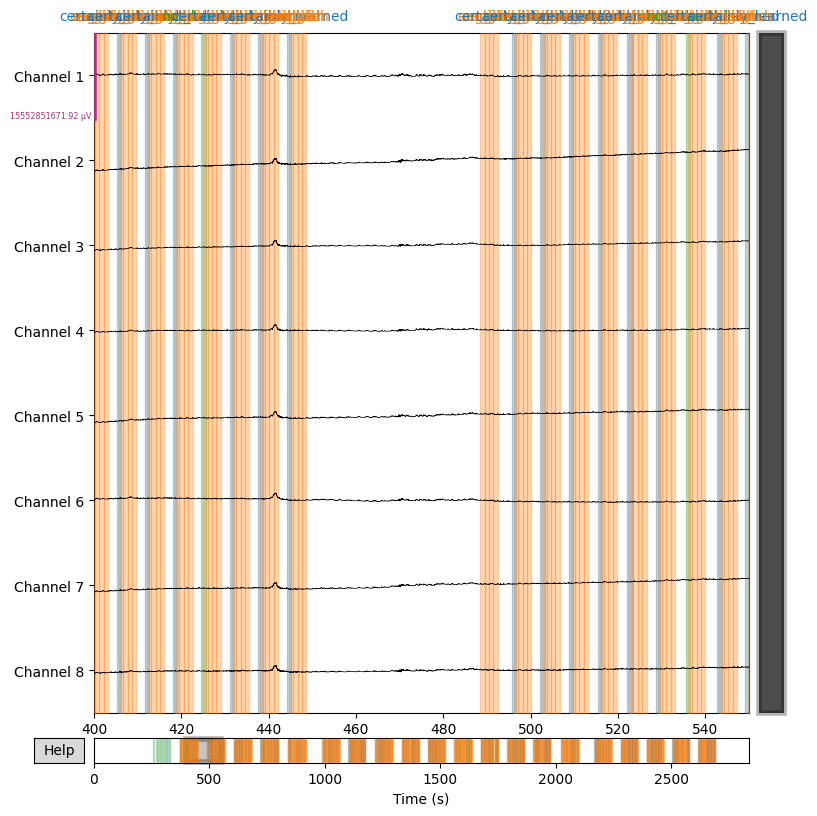

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 8 x 723402 (2836.9 s), ~44.2 MiB, data loaded>

In [14]:
#debugging
print("EEG data time range: 0 to", raw.times[-1], "seconds")  #how long the experiment was in seconds
print("Annotations in raw2:", raw.annotations)               #list of the annotations
print("Adjusted onsets:", raw.annotations.onset)             #the adjusted onsets
raw.plot(start=400, duration=150, scalings='auto', block=True)  # Adjust start and duration as needed
raw.set_eeg_reference(projection=True)  #dont worry

Step 2.5: Filtering... Hopefully this will make it better

In [15]:
#new plot
raw.compute_psd(fmin=0,fmax=50).plot()

#setting high and low band pass filter
f_low = 0.1
f_high = 30
data_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
#low and high pass filter, fir_design can be changed to match what lit review did

#notch filter for electrical noise
data_cleaned.notch_filter(60)



Effective window size : 8.031 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)



C:\Users\cheng\AppData\Local\Temp\ipykernel_23324\34403275.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmin=0,fmax=50).plot()
c:\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1683 samples (6.600 s)



<RawArray | 8 x 723402 (2836.9 s), ~44.2 MiB, data loaded>

Selecting Non noisy data

In [16]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  
#pass in our raw file with all our eeg files
#exclude "bads" discards what signal are identified as bad. 
  #this does a lot of work for us

Artifact removal with ICA

In [17]:
#TODO: determine how many components there are, use 8 for now
ica = ICA(n_components=8, random_state=97, method="fastica")

ica.fit(raw)   
#raw cleaned has been through filtering
#clean will have gone through ica

data_cleaned = ica.apply(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 6.6s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


Step 3: Create an ERP averaging of the annotations

Used Annotations descriptions: [np.str_('certainly_learned'), np.str_('english'), np.str_('not_learned')]
Not setting metadata
1194 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 1194 events and 307 original time points ...
0 bad epochs dropped
Not setting metadata
210 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 210 events and 307 original time points ...
0 bad epochs dropped
Not setting metadata
960 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 960 events and 307 original time points ...
0 bad epochs dropped
Not setting metadata
24 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1

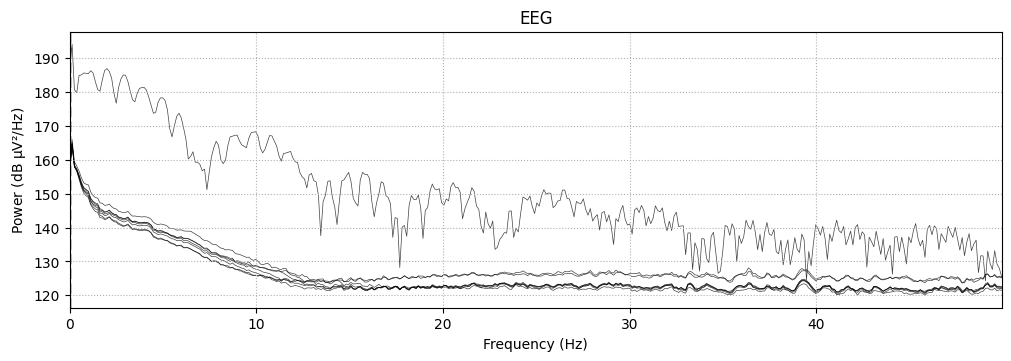

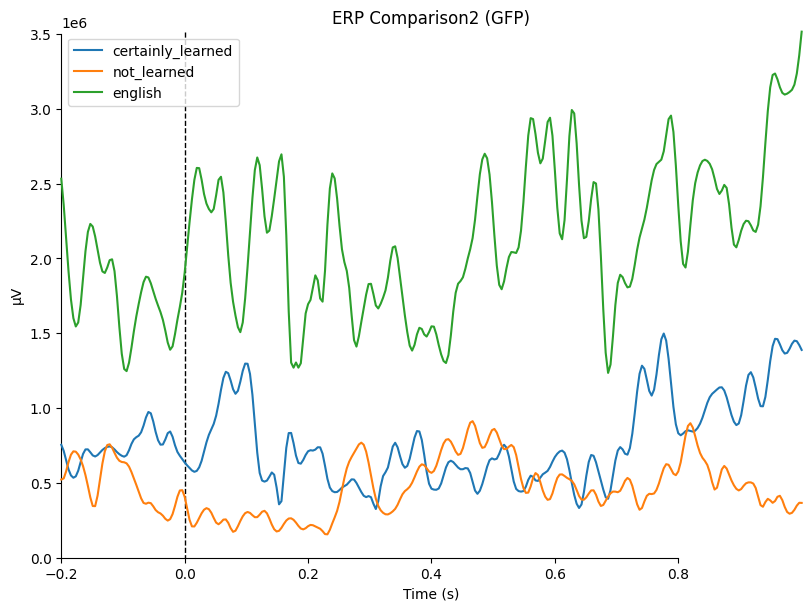

[<Figure size 800x600 with 1 Axes>]

In [ ]:
# NOTE: Had to temporarily remove "learned" annotations because "certainly_learned" had overlapping timestamps.


# Extract events from annotations
events, event_id = mne.events_from_annotations(data_cleaned)

# Define the epoch time window (start and end in seconds relative to event onset)
tmin, tmax = -0.2, 1  # for example, 200ms before and 500ms after each event

#mne expects event ID to be ints and not strings, so we need to change our annotations via dictionary

# Create epochs
event_epochs = mne.Epochs(
    data_cleaned,                # Variable that contains our data
    events,                      # Events we want to investigate, remember we changed T1 and T2 to this
    event_id={"certainly_learned": 1, "not_learned": 2, "english": 3},
	tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

# make different epochs for each label
certainly_learned_event_epochs = mne.Epochs(
    data_cleaned,                # Variable that contains our data
    events,                      # Events we want to investigate, remember we changed T1 and T2 to this
    event_id={"certainly_learned": 1},
	tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

not_learned_event_epochs = mne.Epochs(
    data_cleaned,                # Variable that contains our data
    events,                      # Events we want to investigate, remember we changed T1 and T2 to this
    event_id={"not_learned": 2},
	tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

english_event_epochs = mne.Epochs(
    data_cleaned,                # Variable that contains our data
    events,                      # Events we want to investigate, remember we changed T1 and T2 to this
    event_id={"english": 3},
	tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)


# Compute the average ERP for each event type
evoked_dict = {event: event_epochs[event].average() for event in event_id}

# Plot the ERPs
#mne.viz.plot_compare_evokeds(evoked_dict, picks='eeg', title='ERP Comparison')

# repeat for the other two 
#learned_evoked = learned_event_epochs.average()
certainly_evoked = certainly_learned_event_epochs.average()
not_learned_evoked = not_learned_event_epochs.average()
english_evoked = english_event_epochs.average()


evoked_dict = {"certainly_learned": certainly_evoked, "not_learned": not_learned_evoked, "english": english_evoked}
# "learned" : learned_evoked
mne.viz.plot_compare_evokeds(evoked_dict, picks="eeg", title="ERP Comparison2")


Reducing Dimensionality using PCA

In [19]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

# Step 1: Get epoch data
X_epochs = event_epochs.get_data()
print(f"Original shape: {X_epochs.shape}")  # Shape: (epochs, channels, times) times is the amount of samples. 

# repeat for the other epochs
certainly_learned_epochs = certainly_learned_event_epochs.get_data()
print(f"Original shape: {certainly_learned_epochs.shape}")
#learned_epochs = learned_event_epochs.get_data()
#print(f"Original shape: {learned_epochs.shape}")

not_learned_epochs = not_learned_event_epochs.get_data()
print(f"Original shape: {not_learned_epochs.shape}")

Original shape: (1194, 8, 307)
Original shape: (210, 8, 307)
Original shape: (960, 8, 307)


In [20]:
# Step 2: Apply PCA
n_components = 8
pca_mne = UnsupervisedSpatialFilter(PCA(n_components=n_components), average=False)
X_pca = pca_mne.fit_transform(X_epochs)
print(f"After PCA shape: {X_pca.shape}")  # Shape: (epochs, components, times)

# repeat
certainly_learned_pca = pca_mne.fit_transform(certainly_learned_epochs)
print(f"After PCA shape: {certainly_learned_pca.shape}")

#learned_pca = pca_mne.fit_transform(learned_epochs)
#print(f"After PCA shape: {learned_pca.shape}")

not_learned_pca = pca_mne.fit_transform(not_learned_epochs)
print(f"After PCA shape: {not_learned_pca.shape}")

After PCA shape: (1194, 8, 307)
After PCA shape: (210, 8, 307)
After PCA shape: (960, 8, 307)


Preparing data for Machine Learning 

In [21]:
# Step 3: Reshape data for machine learning
X_flat = X_pca.reshape(X_pca.shape[0], -1)  # Shape: (epochs, components * times)
print(f"Flattened shape: {X_flat.shape}")
print(X_flat)

certainly_learned_flat = certainly_learned_pca.reshape(certainly_learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
print(f"Flattened shape: {certainly_learned_flat.shape}")
print(certainly_learned_flat)

#learned_flat = learned_pca.reshape(learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
#print(f"Flattened shape: {learned_flat.shape}")
#print(learned_flat)

not_learned_flat = not_learned_pca.reshape(not_learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
print(f"Flattened shape: {not_learned_flat.shape}")
print(not_learned_flat)

'''
easier for the machine learning step if we seperate the learned and not learned data
'''

Flattened shape: (1194, 2456)
[[ 2.78549955e+01  2.80631055e+01  2.73988652e+01 ...  4.10374764e-14
   4.31848540e-14  3.44875484e-14]
 [-3.23231557e+01 -3.21159047e+01 -3.03776439e+01 ... -2.45934740e-15
  -2.96666063e-15  1.38284108e-16]
 [-1.37895099e+01 -1.23658487e+01 -1.12755877e+01 ...  1.07298943e-14
   1.22791554e-14  7.89869865e-15]
 ...
 [-1.88517336e+01 -1.67404968e+01 -1.49365745e+01 ... -3.09001932e-15
  -6.11395979e-15  4.67753284e-15]
 [ 1.06298018e+01  1.12268145e+01  1.16199821e+01 ...  1.01953670e-14
   5.89310390e-15  7.10552842e-15]
 [ 2.93131992e+01  2.92467071e+01  2.85352722e+01 ...  4.32744126e-15
  -2.91314798e-15 -4.96528450e-15]]
Flattened shape: (210, 2456)
[[ 2.69412215e+01  2.72585736e+01  2.65913386e+01 ...  1.09034101e-14
   1.31180223e-14  5.01558877e-15]
 [-4.13582386e-01 -8.85712403e-01 -6.72255425e-01 ...  4.23723908e-14
   3.52231622e-14  2.99912344e-14]
 [-1.09693251e+01 -9.69929392e+00 -9.01064229e+00 ... -3.83220355e-14
  -3.82635992e-14 -3.7944

'\neasier for the machine learning step if we seperate the learned and not learned data\n'

In [22]:
# write to a csv
np.savetxt('../processed_EEG_data/JoshIrby.csv',X_flat, delimiter=',', fmt='%f')

np.savetxt('../processed_EEG_data/clean_learned_JoshIrby.csv', certainly_learned_flat, delimiter=',', fmt='%f')
#np.savetxt('../processed_EEG_data/clean_learned_JoshIrby.csv',learned_flat, delimiter=',', fmt='%f')

np.savetxt('../processed_EEG_data/clean_notLearned_JoshIrby.csv',not_learned_flat, delimiter=',', fmt='%f')
